# Create plots used for paper:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install bioinfokit
! pip install sewar
! pip install shapely --no-binary shapely


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 36.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 28.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 42.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.4 MB 33.0 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.18.0-cp37-cp37m-linux_x86_64.whl size=15127784 sha256=fd77eeeca86cab2ed3f609a47cf404a5a87636e2229eb098bf5ca9a0

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files
import math

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('seaborn-white')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rcParams['lines.linewidth'] = 1.5

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Set up CUDA:

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? False
CUDA version: 11.3


### Helper scripts:

In [5]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
from training import *
from prediction import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Drive:

In [6]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

## Load data:

### (Input eval 1) UPRCM:

In [243]:
UPRCM

<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    TTP          (time, y, x) float64 ...
    QQP          (time, y, x) float64 ...
    PR           (time, y, x) float32 ...
    NW           (time, y, x) float64 ...
    EW           (time, y, x) float64 ...
Attributes:
    crs:      3031

In [7]:
%%time
idUPRCM = '1ab88hzzd5D9RIDsI6LdGAKO6DFo_R3L2'
downloaded = Googledrive.CreateFile({'id':idUPRCM}) 
downloaded.GetContentFile(fileUPRCM)  
UPRCM = xr.open_dataset(fileUPRCM)
os.remove(fileUPRCM)

CPU times: user 3.53 s, sys: 909 ms, total: 4.44 s
Wall time: 18.2 s


### (Input eval 2) Real GCM:

In [8]:
idGCM = '1Rq4tIPxNTPtTonaMe1gi6PxHmLwgy8D-'
downloaded = Googledrive.CreateFile({'id':idGCM}) 
downloaded.GetContentFile(fileGCM)  
GCM = xr.open_dataset(fileGCM)
os.remove(fileGCM)
GCM = GCM.rename_vars({'ps':'SP', 'uas':'EW', 'vas':'NW', 'pr':'PR', 
                       'tas': 'TT', 
                       'rsds':'SWD', 'rlds':'LWD', 'huss':'QQP', 'hurs':'RH'})
GCM['TT'].attrs["units"] = "C"
GCM  = GCM.drop(['RH'])

### (Target) RCM:

In [9]:
%%time
idTarget = '1r8mVOIo6GDTe6fHb9EZikZMdwPHurHSe'
downloaded = Googledrive.CreateFile({'id':idTarget}) 
downloaded.GetContentFile(fileTarget) 
target_dataset = xr.open_dataset(fileTarget)
os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen({'time': 1452, 'x': 176, 'y': 148})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160})
CPU times: user 2.28 s, sys: 492 ms, total: 2.77 s
Wall time: 7.21 s


## Create test data:

In [10]:
# difference between both
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
  
# variables in UPRCM
all_vars_RCM = sorted(list(UPRCM.data_vars))
all_vars_GCM = sorted(list(GCM.data_vars))

# variables we want to train on:
vars =['PR', 'SP', 'LWD','SWD','TT', 'EW', 'NW', 'QQP']

print('Variables in UPRCM:',all_vars_RCM)
print('Variables in GCM:', sorted(list(GCM.data_vars)))
print('Variables to drop in UPRCM:', Diff(all_vars_RCM, vars))
print('Variables to drop in GCM:', Diff(all_vars_GCM, vars))

Variables in UPRCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'RF', 'SF', 'SMB', 'SP', 'SWD', 'TT', 'TTP']
Variables in GCM: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Variables to drop in UPRCM: ['SMB', 'TTP', 'RF', 'SF']
Variables to drop in GCM: []


In [11]:
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    seed=SEED,
    amp=AMP,
    test_percent=TEST_PERCENT,
    val_percent=VAL_PERCENT,
    loss_=LOSS_,
    typeNet=TYPENET,
)

In [12]:
REGION = "Larsen"
LOSS_ = "NRMSE"
TYPENET = "Attention"
REGIONS = [REGION]

#### Targets:

In [13]:
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)

# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Create mask over ice/land
mask = createMask(full_target[0, :, :], onechannel=True)

#### UPRCM input:

In [14]:
# UPRCM input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=None,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)


# Test set from UPRCM: 
print('Creating UPRCM dataset:\n------------------')
train_set_UPRCM, test_set_UPRCM, net_UPRCM = trainFlow(
    full_input,
    full_target,
    mask,
    region=REGION,
    train=False,
    randomSplit=False,
    **trainingParam,
)

Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']


INFO: Using device cpu
INFO: Attention SmAt_UNet model


Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 18)
Creating UPRCM dataset:
------------------


INFO: Network:
	8 input channels X
	18 input channels Z
	Transposed conv upscaling
INFO: X shape: torch.Size([1452, 8, 32, 32])
INFO: Test set size: 120
Train set size: 1332



#### GCM input:

In [15]:
# GCM input
i1D_GCM, i2D_GCM, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    UPRCM=UPRCM,
    GCM=GCM,
    size_input_domain=SIZE_INPUT_DOMAIN,
    Region=REGION,
    dropvarGCM=None,
    dropvarRCM=["RF", "SF", "TTP"],
)
full_input_GCM = [np.concatenate([i2D_GCM], axis=0), np.concatenate([i1D_GCM], axis=0)]

# Test set from GCM: 
print('Creating GCM dataset:\n------------------')
train_set_GCM, test_set_GCM, net_GCM = trainFlow(
    full_input_GCM,
    full_target,
    mask,
    region=REGION,
    train=False,
    randomSplit=False,
    **trainingParam,
)

Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']
Variables: ['EW', 'LWD', 'NW', 'PR', 'QQP', 'SP', 'SWD', 'TT']


INFO: Using device cpu
INFO: Attention SmAt_UNet model


Creating GCM dataset:
------------------


INFO: Network:
	8 input channels X
	18 input channels Z
	Transposed conv upscaling
INFO: X shape: torch.Size([1452, 8, 32, 32])
INFO: Test set size: 120
Train set size: 1332



### Load saved models:

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Load saved models
today = str(date.today())

modelUPRCM = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}_UPRCM.pth"
modelGCM = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}_{TYPENET}_{LOSS_}_GCM.pth"

downloadModel = True
if downloadModel:
    # Download from google drive
    print("Loading UPRCM-Attention model:")
    idModel = '1Y0XTawQXBTporNnOtib2rAaHhStrD8er'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(modelUPRCM)
    print('Done!')

    # Download from google drive
    print("Loading GCM-Attention model")
    idModel = '12AZ5mB801ql8g8ovAC8uv1yHE5v6bRxo'
    downloaded = Googledrive.CreateFile({"id": idModel})
    downloaded.GetContentFile(modelGCM)
    print('Done!')

Loading UPRCM-Attention model:
Done!
Loading GCM-Attention model
Done!


## Predictions:

###  UPRCM Model:
Predictions of Emulator trained on UPRCM

In [18]:
# Predictions on UPRCM
print("Predicting on UPRCM dataset:\n------------------")
(   preds_Larsen_NRMSE,
    x_Larsen_NRMSE,
    z_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    r_Larsen_NRMSE,
    loss_mse,
    loss_nrmse,
    loss_rmse,
) = predict(net_UPRCM, device, test_set_UPRCM, modelUPRCM, log_ = False)

# Predictions on GCM
print("Predicting on GCM dataset:\n------------------")
(   preds_Larsen_NRMSE_GCM,
    x_Larsen_NRMSE_GCM,
    z_Larsen_NRMSE_GCM,
    true_smb_Larsen_NRMSE_GCM,
    r_Larsen_NRMSE_GCM,
    loss_mse,
    loss_nrmse,
    loss_rmse,
) = predict(net_GCM, device, test_set_GCM, modelUPRCM, log_ = False)

Predicting on UPRCM dataset:
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting on GCM dataset:
------------------


###  GCM Model:
Predictions of Emulator trained on GCM

In [19]:
# Predictions on GCM
print("Predicting on GCM dataset:\n------------------")
(   preds_Larsen_NRMSE_GCM_tr,
    x_Larsen_NRMSE_GCM_tr,
    z_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE_GCM_tr,
    r_Larsen_NRMSE_GCM_tr,
    loss_mse_tr,
    loss_nrmse_tr,
    loss_rmse_tr,
) = predict(net_GCM, device, test_set_GCM, modelGCM, log_=False)

Predicting on GCM dataset:
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Results:

In [67]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
from training import *
from prediction import *
from pred_plots_paper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Evaluation metrics:

In [21]:
metricsUPRCM = calculateMetrics(
    preds_Larsen_NRMSE,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_UPRCM,
    REGION,
    ignoreSea=True,
)

metricsGCM = calculateMetrics(
    preds_Larsen_NRMSE_GCM,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_GCM,
    REGION,
    ignoreSea=True,
)

metricsGCM_tr = calculateMetrics(
    preds_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE,
    target_dataset,
    train_set_GCM,
    REGION,
    ignoreSea=True,
)

/content/metrics.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  predictions = torch.tensor(preds).clone().detach()
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/content/metrics.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(preds).clone().detach()
/content/metrics.py:41: UserWarning: To copy construct from a tensor, it is recommended

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naci

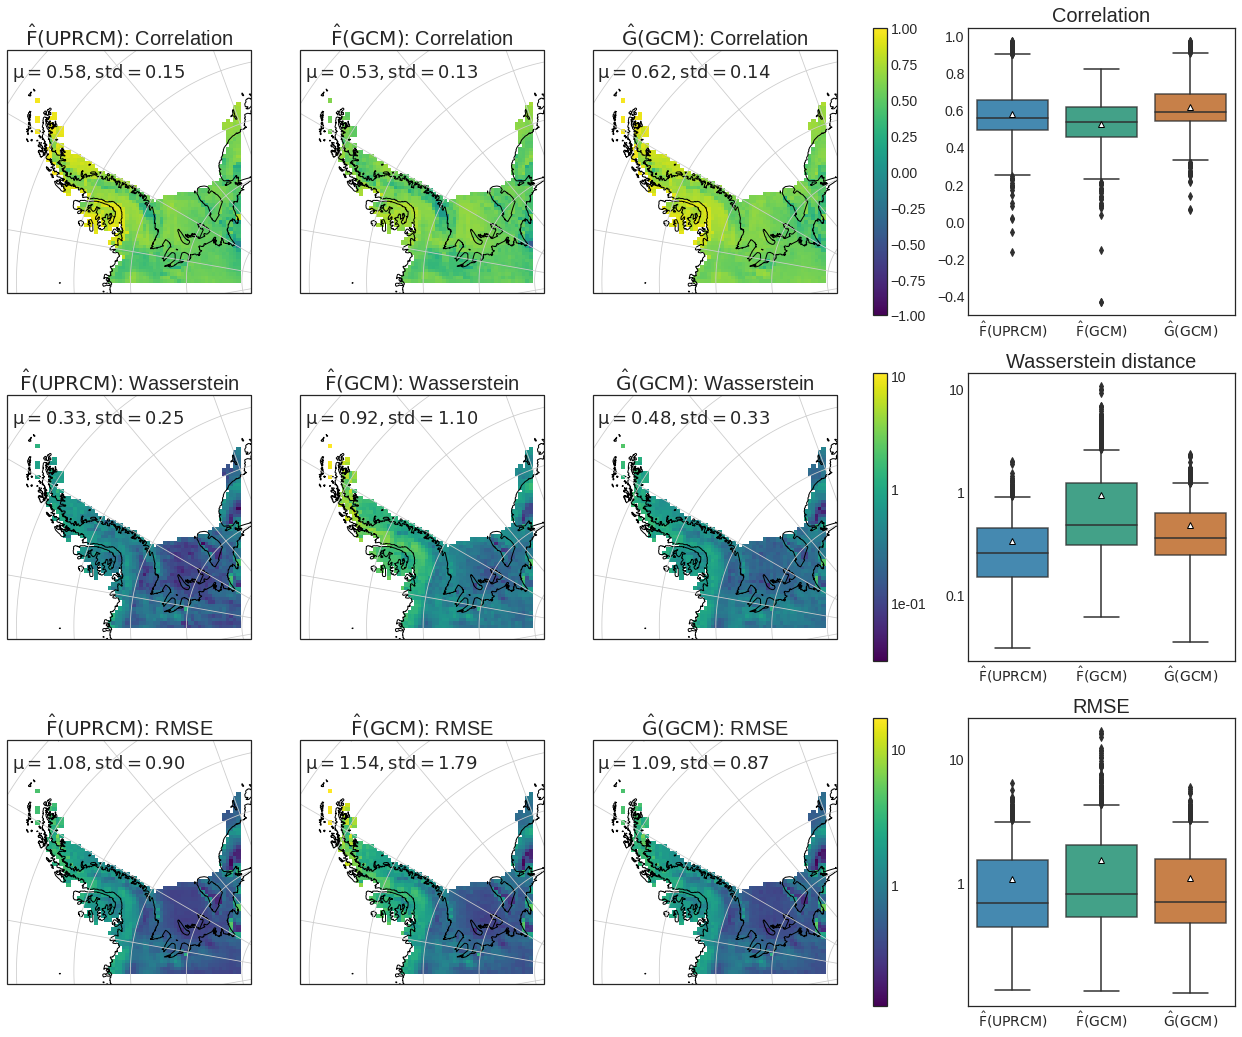

In [22]:
labels = ['$\mathrm{\operatorname{\hat{F}(UPRCM)}}$', '$\mathrm{\operatorname{\hat{F}(GCM)}}$', 
          '$\mathrm{\operatorname{\hat{G}(GCM)}}$']

CompareMetrics3Models(
    PearsonCorr = [metricsUPRCM["PearsonCorr"], metricsGCM["PearsonCorr"], metricsGCM_tr["PearsonCorr"]],
    Wasserstein = [metricsUPRCM["Wasserstein"], metricsGCM["Wasserstein"], metricsGCM_tr["Wasserstein"]],
    RMSE = [metricsUPRCM["RMSE"], metricsGCM["RMSE"], metricsGCM_tr["RMSE"]],
    target_dataset = target_dataset,
    region="Larsen",
    labels=labels,
    figsize=(22, 18),
)


### Geoplots:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


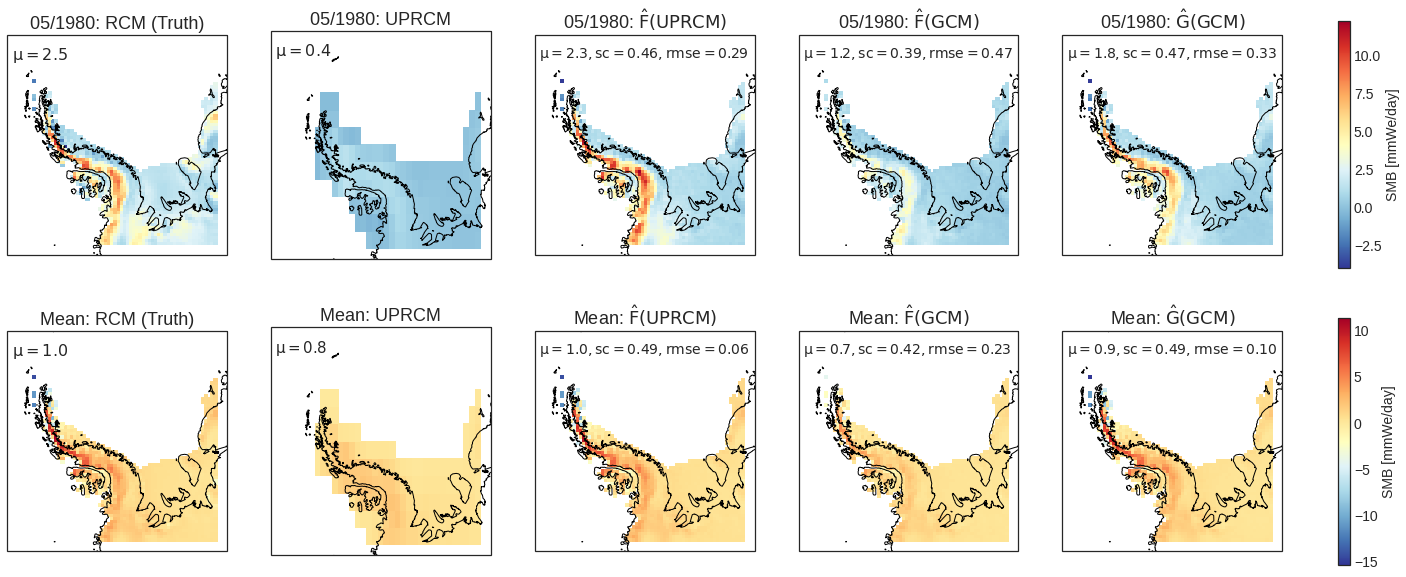

In [71]:
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 31, "y": 26},
    {"x": 52, "y": 17},
)
plotPredictions3Models(
    preds_Larsen_NRMSE,
    preds_Larsen_NRMSE_GCM,
    preds_Larsen_NRMSE_GCM_tr,
    true_smb_Larsen_NRMSE_GCM,
    r_Larsen_NRMSE_GCM,
    UPRCM,
    target_dataset,
    points_RCM,
    figsize = (25, 10),
    fontsize_axes = 18,
    fontsize_suptitle = 24,
)

### Timeseries:

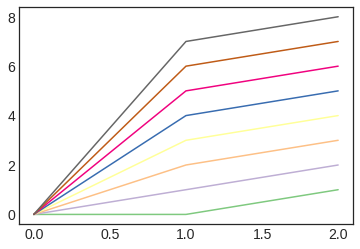

In [24]:
cmap = plt.cm.get_cmap('Accent', 8)    # PiYG
pastelcolors = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    pastelcolors.append(matplotlib.colors.rgb2hex(rgba))
ax = plt.subplot(1,1,1)
for i in range(len(pastelcolors)):
  ax.plot([0,1,2], [0,i,i+1], c = pastelcolors[i])

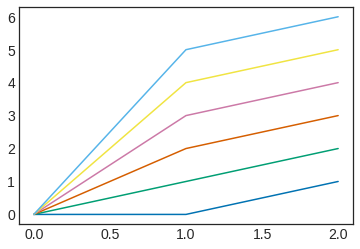

In [25]:
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']
ax = plt.subplot(1,1,1)
for i in range(len(colors)):
  ax.plot([0,1,2], [0,i,i+1], c = colors[i])

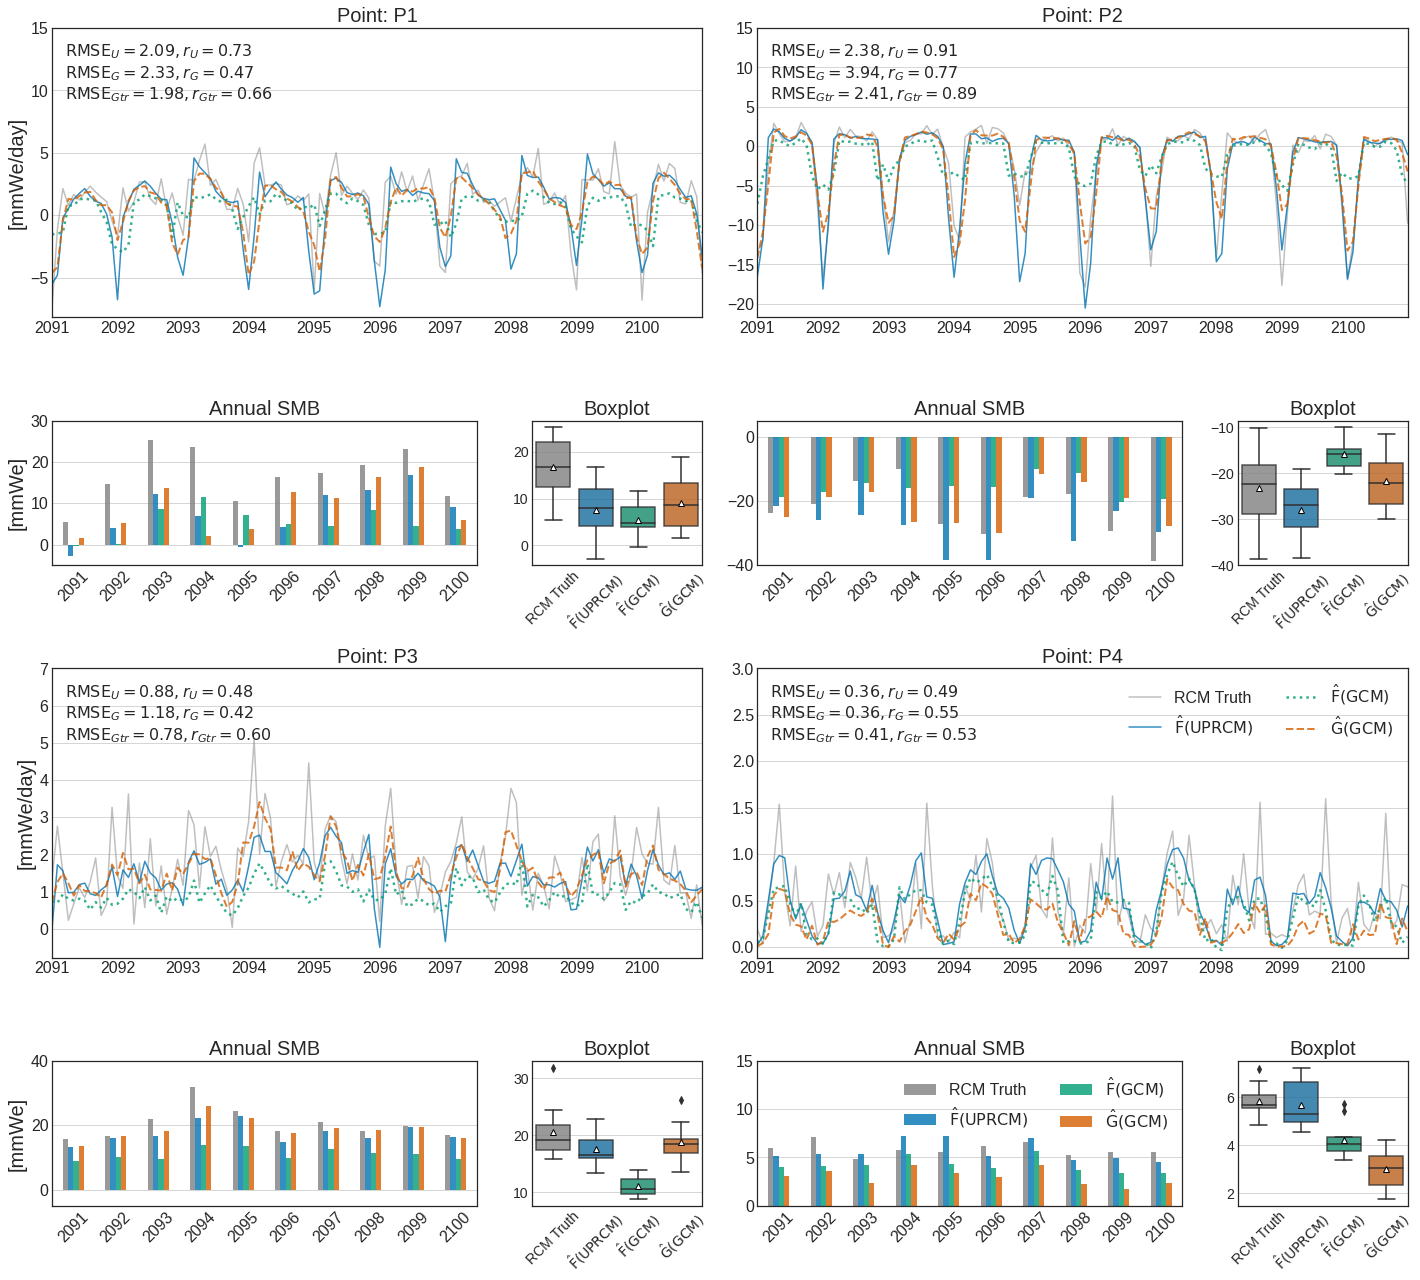

In [26]:
points_RCM = (
    {"x": 16, "y": 32},
    {"x": 27, "y": 22},
    {"x": 31, "y": 26},
    {"x": 52, "y": 17},
)

labels = ['$\mathrm{\operatorname{\hat{F}(UPRCM)}}$', '$\mathrm{\operatorname{\hat{F}(GCM)}}$', 
          '$\mathrm{\operatorname{\hat{G}(GCM)}}$', 'RCM Truth']
yearlySMB = plotTimeseries3Models(
    preds1 = preds_Larsen_NRMSE,
    preds2 = preds_Larsen_NRMSE_GCM,
    preds3 = preds_Larsen_NRMSE_GCM_tr,
    true_smb = true_smb_Larsen_NRMSE,
    train_set = train_set_GCM,
    target_dataset = target_dataset,
    points_RCM = points_RCM,
    region = REGION,
    figsize=(20, 18),
    labels = labels
)

### Temporal and spatial correlation:

In [38]:
LarsenUPRCM = createLowerInput(UPRCM, region="Larsen", Nx=48, Ny=25, print_=False)
LarsenUPRCM = LarsenUPRCM.where(LarsenUPRCM.y>0, drop=True)
LarsenGCM = createLowerInput(GCM, region="Larsen", Nx=48, Ny=25, print_=False)
LarsenGCM = LarsenGCM.where(LarsenGCM.y>0, drop=True)

# Test time:
testTime = LarsenUPRCM.isel(time = slice(len(train_set_UPRCM), LarsenUPRCM.dims['time'])).time.values

# Slice over test period:
LarsenUPRCM = LarsenUPRCM.isel(time = slice(len(train_set_UPRCM), LarsenUPRCM.dims['time']))
LarsenGCM = LarsenGCM.isel(time = slice(len(train_set_UPRCM), LarsenGCM.dims['time']))

#### Temporal correlation:

In [28]:
def temporalCorr_UPRCM_GCM(LarsenUPRCM, LarsenGCM, UPRCM, variables, longNames, figsize = (15, 6)):
  fig = plt.figure(figsize = figsize)
  axs,axs2 =[], []
  for i, var in enumerate(variables):
    var1 = np.expand_dims(LarsenUPRCM[var].values,3)
    var2 = np.expand_dims(LarsenGCM[var].values,3)
    pearson = calculatePearson(var1, var2, ignoreSea=True)
    
    ax = plt.subplot(2,4,i+1, projection=ccrs.SouthPolarStereo())
    if i+1 < 5:
      axs.append(ax)
    else:
      axs2.append(ax)

    im = plotPearsonCorr(UPRCM, pearson, ax = ax, 
                    mean = np.nanmean(pearson), type = 'GCM', colorbar = False)
    
    ax.set_title('{}'.format(longNames[i]), fontsize = 16)
    textstrBoxplots = "\n".join((r"$\mathrm{\mu}=%.2f, \mathrm{std}=%.2f$"% (np.nanmean(pearson), np.nanstd(pearson)),))
    ax.text(0.04, 0.95,textstrBoxplots,
            transform=ax.transAxes,
            fontsize=15,
            verticalalignment="top", color = 'white')

  clb = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
  clb.set_label("Pearson Correlation")
  clb2 = fig.colorbar(im, ax=axs2, fraction=0.046, pad=0.04)
  clb2.set_label("Pearson Correlation")

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:402: ShapelyDeprecationWarning: Iteration over multi-pa

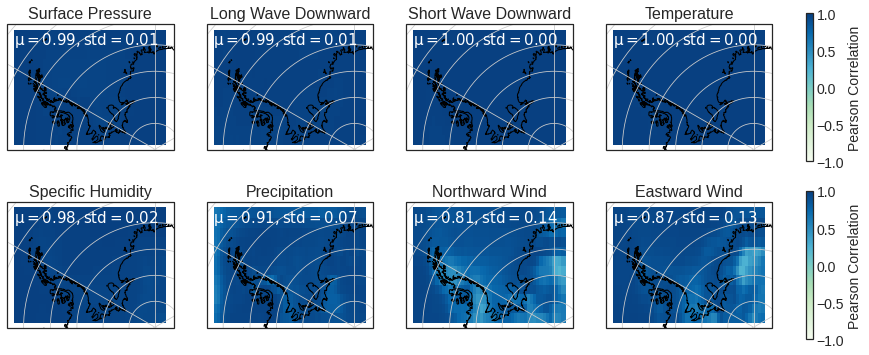

In [33]:
variables = ['SP', 'LWD', 'SWD', 'TT', 'QQP', 'PR', 'NW', 'EW']
longNames = ['Surface Pressure', 'Long Wave Downward', 'Short Wave Downward', 
             'Temperature', 'Specific Humidity', 'Precipitation', 'Northward Wind', 'Eastward Wind']

temporalCorr_UPRCM_GCM(LarsenUPRCM, LarsenGCM, UPRCM, variables, longNames, figsize = (15, 6))

In [240]:
def SpatialCorrDF(LarsenGCM, LarsenUPRCM, testTime, list_vars):
  correlations = pd.DataFrame(index=testTime,)
  for i, var in enumerate(list_vars):
    c_arr = []
    for t in testTime:
      im1 = LarsenGCM[var].sel(time = t).values
      im2 = LarsenUPRCM[var].sel(time = t).values
      c_arr.append(scc(im1, im2)) # spatial correlation
    correlations[var] = c_arr
  return correlations

In [241]:
def getMinMaxCorrVars(vars, correlations):
  minsmax = {}
  minsmaxShort = {}
  for var in vars:
    minvalue = np.abs(correlations[var]).argmin()
    maxvalue = np.abs(correlations[var]).argmax()
    minsmax[var] = [correlations.index[minvalue].strftime("%Y-%m-%d"), correlations.index[maxvalue].strftime("%Y-%m-%d")]
    minsmaxShort[var] = [correlations.index[minvalue].strftime("%m/%Y"), correlations.index[maxvalue].strftime("%m/%Y")]
  return minsmax, minsmaxShort


def spatialCorr(correlations, figsize = (18, 3)):
  M, N, i = 1, 4, 1
  fig = plt.figure(figsize = figsize)
  colors = ['#0072b2', '#d55e00']
  
  min = np.min(correlations.min())-0.1
  vars = ['PR', 'LWD', 'SWD']
  minsmax, minsmaxShort =  getMinMaxCorrVars(vars, correlations)

  ax1 = plt.subplot(M, N, i)
  ax1.plot(correlations.index, correlations['QQP'], label = 'QQP', c = colors[0])
  ax1.plot(correlations.index, correlations['TT'], label = 'TT', c = colors[1])
  #ax1.axes.get_xaxis().set_visible(False)

  i+=1
  ax2 = plt.subplot(M, N, i)
  ax2.plot(correlations.index, correlations['LWD'], label = 'LWD', c = colors[0])
  ax2.plot(correlations.index, correlations['SWD'], label = 'SWD', c = colors[1])
  ax2.scatter(correlations.loc[minsmax['LWD']]['LWD'].index, correlations.loc[minsmax['LWD']]['LWD'].values)
  ax2.scatter(correlations.loc[minsmax['SWD']]['SWD'].index, correlations.loc[minsmax['SWD']]['SWD'].values)  
  #ax2.axes.get_xaxis().set_visible(False)

  i+=1
  ax3 = plt.subplot(M, N, i,  sharex = ax1)
  ax3.plot(correlations.index, correlations['EW'], label = 'EW', c = colors[0])
  ax3.plot(correlations.index, correlations['NW'], label = 'NW', c = colors[1])

  i+=1
  ax4 = plt.subplot(M, N, i, sharex = ax2)
  ax4.plot(correlations.index, correlations['PR'], label = 'PR', c = colors[0])

  x = correlations.loc[minsmax['PR']]['PR'].index
  y = correlations.loc[minsmax['PR']]['PR'].values
  ax4.scatter(x, y)
  ax4.plot(correlations.index, correlations['SP'], label = 'SP', c = colors[1])

  for ax in [ax1, ax2, ax3, ax4]:
    ax.legend(loc = 'upper right', ncol = 2)
    ax.set_ylim(top = 1, bottom = min)
    ax.grid(axis = 'y')
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 24))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

/usr/local/lib/python3.7/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float64 and float32
  warnings.warn(msg)


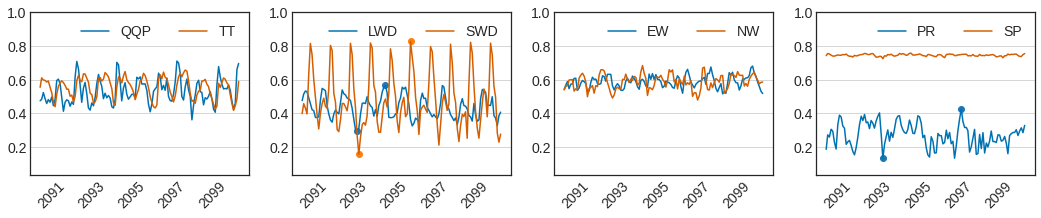

In [242]:
import matplotlib.dates as mdates

list_vars = ['SP', 'LWD', 'SWD', 'TT', 'QQP', 'PR', 'NW', 'EW']
correlations =  SpatialCorrDF(LarsenGCM, LarsenUPRCM, testTime, list_vars)
spatialCorr(correlations, figsize = (18, 3))

/usr/local/lib/python3.7/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


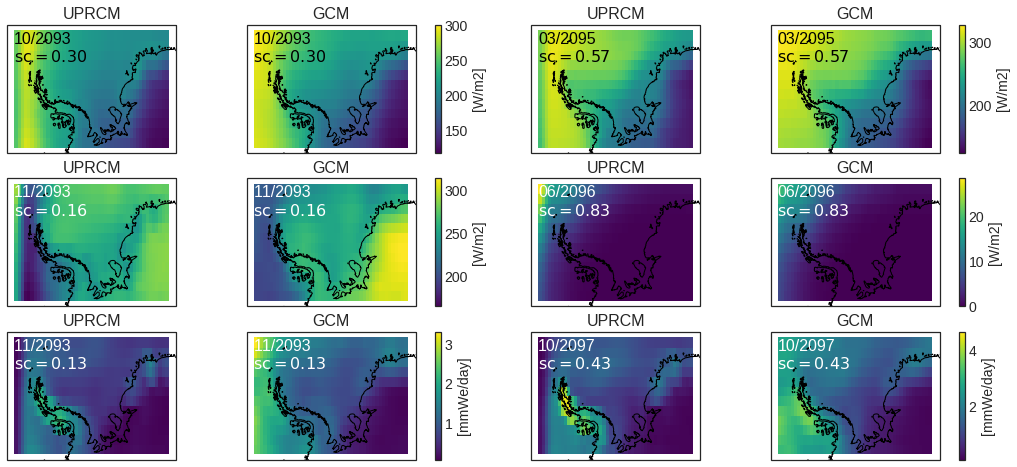

In [168]:
fig = plt.figure(figsize = (18, 8))

# --------- LWD -----------
var = 'LWD'
# Min:
im1 = LarsenUPRCM[var].sel(time = minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time = minsmax[var][0]).values
ax1= plt.subplot(3,4,1, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time = minsmax[var][0]).plot(ax=ax1,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax1.set_title(f'UPRCM')

ax2= plt.subplot(3,4,2, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time = minsmax[var][0]).plot(ax=ax2,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax2.set_title('GCM')

for ax in [ax1, ax2]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][0]}", r"$\mathrm{sc}=%.2f$"% (scc(im1, im2))))
  ax.text(0.04, 0.95,textstrBoxplots,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top", color = 'black')
clb = fig.colorbar(cl, ax=[ax1, ax2], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# Max:
im1 = LarsenUPRCM[var].sel(time = minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time = minsmax[var][1]).values

ax3 = plt.subplot(3,4,3, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time = minsmax[var][1]).plot(ax=ax3,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False, 
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax3.set_title(f'UPRCM')

ax4 = plt.subplot(3,4,4, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time = minsmax[var][1]).plot(ax=ax4,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax4.set_title('GCM')

for ax in [ax3, ax4]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][1]}",r"$\mathrm{sc}=%.2f$"% (scc(im1, im2)),))
  ax.text(0.04, 0.95,textstrBoxplots,
          transform=ax.transAxes,
          fontsize=16,
          verticalalignment="top", color = 'black')
clb = fig.colorbar(cl, ax=[ax3, ax4], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# --------- SWD -----------
# Min
var = 'SWD'
im1 = LarsenUPRCM[var].sel(time =  minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time =  minsmax[var][0]).values
ax5= plt.subplot(3,4,5, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time =  minsmax[var][0]).plot(ax=ax5,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax5.set_title(f'UPRCM')

ax6= plt.subplot(3,4,6, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time =  minsmax[var][0]).plot(ax=ax6,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax6.set_title('GCM')

for ax in [ax6, ax5]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][0]}",r"$\mathrm{sc}=%.2f$"% (scc(im1, im2)),))
  ax.text(0.04, 0.95,textstrBoxplots,
          transform=ax.transAxes,
          fontsize=16,
          verticalalignment="top", color = 'white')
clb = fig.colorbar(cl, ax=[ax5, ax6], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# Max:
im1 = LarsenUPRCM[var].sel(time =  minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time =  minsmax[var][1]).values

ax7 = plt.subplot(3,4,7, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time =  minsmax[var][1]).plot(ax=ax7,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False, 
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax7.set_title(f'UPRCM')

ax8 = plt.subplot(3,4,8, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time =  minsmax[var][1]).plot(ax=ax8,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax8.set_title('GCM')

for ax in [ax7, ax8]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][1]}",r"$\mathrm{sc}=%.2f$"% (scc(im1, im2)),))
  ax.text(0.04, 0.95,textstrBoxplots,
          transform=ax.transAxes,
          fontsize=16,
          verticalalignment="top", color = 'white')
clb = fig.colorbar(cl, ax=[ax7, ax8], fraction=0.046, pad=0.04)
clb.set_label("[W/m2]")

# --------- PR -----------
# Min:
var = 'PR'
im1 = LarsenUPRCM[var].sel(time =  minsmax[var][0]).values
im2 = LarsenGCM[var].sel(time =  minsmax[var][0]).values
ax9= plt.subplot(3,4,9, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time =  minsmax[var][0]).plot(ax=ax9,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax9.set_title(f'UPRCM')

ax10= plt.subplot(3,4,10, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time =  minsmax[var][0]).plot(ax=ax10,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax10.set_title('GCM')

for ax in [ax9, ax10]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][0]}",r"$\mathrm{sc}=%.2f$"% (scc(im1, im2)),))
  ax.text(0.04, 0.95,textstrBoxplots,
          transform=ax.transAxes,
          fontsize=16,
          verticalalignment="top", color = 'white')
clb = fig.colorbar(cl, ax=[ax9, ax10], fraction=0.046, pad=0.04)
clb.set_label("[mmWe/day]")

# Max:
im1 = LarsenUPRCM[var].sel(time =  minsmax[var][1]).values
im2 = LarsenGCM[var].sel(time =  minsmax[var][1]).values

ax11 = plt.subplot(3,4,11, projection=ccrs.SouthPolarStereo())
cl = LarsenUPRCM[var].sel(time =  minsmax[var][1]).plot(ax=ax11,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False, 
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax11.set_title(f'UPRCM')

ax12 = plt.subplot(3,4,12, projection=ccrs.SouthPolarStereo())
cl = LarsenGCM[var].sel(time =  minsmax[var][1]).plot(ax=ax12,
        x="x",
        transform=ccrs.SouthPolarStereo(),
        add_colorbar=False,
        vmin = np.nanmin([im1, im2]),
        vmax = np.nanmax([im1, im2]))
ax12.set_title('GCM')

for ax in [ax11, ax12]:
  textstrBoxplots = "\n".join((f"{minsmaxShort[var][1]}",r"$\mathrm{sc}=%.2f$"% (scc(im1, im2)),))
  ax.text(0.04, 0.95,textstrBoxplots,
          transform=ax.transAxes,
          fontsize=16,
          verticalalignment="top", color = 'white')
clb = fig.colorbar(cl, ax=[ax11, ax12], fraction=0.046, pad=0.04)
clb.set_label("[mmWe/day]")


for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
  ax.coastlines("10m", color="black", linewidth = 1)